#Experiment 4: Hyper-parameter tuning for a BPNN
##1. Objective
WAP to evaluate the performance of implemented three-layer neural network with variations in activation functions, size of hidden layer, learning rate, batch size and number of epochs.

##2. Description of the Model
This model is a simple feedforward neural network (FNN) and backpropagation neural network(BPNN) designed for classifying handwritten digits from the MNIST dataset. The architecture consists of:

- Input Layer: 784 neurons (flattened 28×28 grayscale images)
- Hidden Layer 1 and Hidden Layer 2: are varied in range [(160, 100), (100, 100), (100, 160), (60, 60), (100, 60)] with activation function as Relu
- Output Layer: 10 neurons (one for each digit 0-9), using raw logits
- Learning Rate:is also varied between [0.01, 0.1, 1]
- Loss Function: Softmax cross-entropy
- Optimizer: Adam Optimizer
- Performance Metrics: Accuracy,loss curves, confusion matrix
- The model is trained for 50 epochs with batch size = 10.

##3.My Comments
### Issues:
- Accuracy never reaches above 95%

### Scope for Improvement:
- Replace Sigmoid with ReLU for faster learning as it is better activation function.
- Hyperparameter tuning (learning rate, batch size) can be done more accurately to optimize performance.
- Use of Adam optmizer over Gradient Descent to gain more accuracy

##Python Implementation


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import pandas as pd
import json
from sklearn.metrics import confusion_matrix

# Disable eager execution for TF 2.x compatibility with TF 1.x code
tf.compat.v1.disable_eager_execution()

# Load MNIST dataset
mnist_data = tfds.load("mnist", as_supervised=True)
train_data, test_data = mnist_data["train"], mnist_data["test"]

### Load & Preprocess MNIST Dataset



In [ ]:
# Preprocess function: Flatten and Normalize
def preprocess(image, label):
    image = tf.reshape(image, [-1])  # Flatten (28x28 → 784)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize (0-255 → 0-1)
    label = tf.one_hot(label, depth=10)  # One-hot encode
    return image, label

# Training parameters
batch_size = 10
num_epochs = 50
steps_per_epoch = 60000 // batch_size  # MNIST has 60,000 training images

# Apply preprocessing, shuffle, and batch
train_data = train_data.map(preprocess).shuffle(10000).batch(batch_size)
test_data = test_data.map(preprocess).batch(batch_size)

# Define placeholders
X = tf.compat.v1.placeholder(tf.float32, shape=[None, 784])
Y = tf.compat.v1.placeholder(tf.float32, shape=[None, 10])

In [ ]:
# Store results
results = []
time_records = []
accuracy_curves = {}
loss_curves = {}
confusion_matrices = {}

hidden_layer_configs = [(160, 100), (100, 100), (100, 160)]
learning_rates = [0.01, 0.1, 1]

In [ ]:
# Define network parameters
def create_network(h1, h2):
    weights = {
        "h1": tf.Variable(tf.random.normal([784, h1])),
        "h2": tf.Variable(tf.random.normal([h1, h2])),
        "out": tf.Variable(tf.random.normal([h2, 10])),
    }
    biases = {
        "b1": tf.Variable(tf.random.normal([h1])),
        "b2": tf.Variable(tf.random.normal([h2])),
        "out": tf.Variable(tf.random.normal([10])),
    }
    return weights, biases

In [ ]:
# Define forward propagation function
def forward_propagation(x, weights, biases):
    layer1 = tf.nn.relu(tf.add(tf.matmul(x, weights["h1"]), biases["b1"]))
    layer2 = tf.nn.relu(tf.add(tf.matmul(layer1, weights["h2"]), biases["b2"]))
    output_layer = tf.add(tf.matmul(layer2, weights["out"]), biases["out"])
    return output_layer

###We would be training 9 configuration:
- hidden_layer_configs = [(160, 100), (100, 100), (100, 160)]
- learning_rates = [0.01, 0.1, 1]



In [ ]:
with tf.compat.v1.Session() as sess:
    for h1, h2 in hidden_layer_configs:
        for lr in learning_rates:
            print(f"Training with hidden layers ({h1}, {h2}) and learning rate {lr}")
            start_time = time.time()

            # Create network
            weights, biases = create_network(h1, h2)
            logits = forward_propagation(X, weights, biases)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
            optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=lr).minimize(loss)
            correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            sess.run(tf.compat.v1.global_variables_initializer())
            iterator = tf.compat.v1.data.make_initializable_iterator(train_data)
            next_batch = iterator.get_next()

            accuracy_list = []
            loss_list = []

            for epoch in range(num_epochs):
                sess.run(iterator.initializer)
                avg_loss = 0
                avg_accuracy = 0

                for _ in range(steps_per_epoch):
                    try:
                        batch_x, batch_y = sess.run(next_batch)
                        _, l, acc = sess.run([optimizer, loss, accuracy], feed_dict={X: batch_x, Y: batch_y})
                        avg_loss += l / steps_per_epoch
                        avg_accuracy += acc / steps_per_epoch
                    except tf.errors.OutOfRangeError:
                        sess.run(iterator.initializer)

                accuracy_list.append(avg_accuracy)
                loss_list.append(avg_loss)
                print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy*100:.2f}%")
            print(f"Final Training Accuracy for hidden layers ({h1}, {h2}) and learning rate {lr} : {avg_accuracy*100:.2f}%")

            accuracy_curves[(h1, h2, lr)] = accuracy_list
            loss_curves[(h1, h2, lr)] = loss_list

            iterator_test = tf.compat.v1.data.make_initializable_iterator(test_data)
            next_test_batch = iterator_test.get_next()
            test_accuracy = 0
            test_steps = 10000 // batch_size
            sess.run(iterator_test.initializer)
            y_true, y_pred = [], []

            for _ in range(test_steps):
                batch_x, batch_y = sess.run(next_test_batch)
                acc, preds = sess.run([accuracy, tf.argmax(logits, 1)], feed_dict={X: batch_x, Y: batch_y})
                test_accuracy += acc / test_steps
                y_true.extend(np.argmax(batch_y, axis=1))
                y_pred.extend(preds)

            confusion_matrices[(h1, h2, lr)] = confusion_matrix(y_true, y_pred)
            results.append(((h1, h2), lr, test_accuracy * 100, time.time() - start_time))

            # Save results after each configuration
            np.save("/content/drive/MyDrive/NN_LAB/exp4_output/accuracy_curves_final1.npy", accuracy_curves)
            np.save("/content/drive/MyDrive/NN_LAB/exp4_output/loss_curves_final1.npy", loss_curves)
            np.save("/content/drive/MyDrive/NN_LAB/exp4_output/confusion_matrices_final1.npy", confusion_matrices)
            # with open("/content/drive/MyDrive/NN_LAB/exp4_output/results_final1.json", "w") as f:
                # json.dump(results, f)
            with open("/content/drive/MyDrive/NN_LAB/exp4_output/results_final1.json", "w") as f:
                  # Convert NumPy floats to native Python floats before serializing
                  json.dump([[tuple(elem[0]), float(elem[1]), float(elem[2]), float(elem[3])] for elem in results], f)

Training with hidden layers (160, 100) and learning rate 0.01
Epoch 1, Loss: 7.0087, Accuracy: 76.04%
Epoch 2, Loss: 0.7040, Accuracy: 83.70%
Epoch 3, Loss: 0.5541, Accuracy: 88.49%
Epoch 4, Loss: 0.4871, Accuracy: 90.20%
Epoch 5, Loss: 0.4985, Accuracy: 90.20%
Epoch 6, Loss: 0.4674, Accuracy: 90.59%
Epoch 7, Loss: 0.4631, Accuracy: 90.67%
Epoch 8, Loss: 0.4560, Accuracy: 90.93%
Epoch 9, Loss: 0.4636, Accuracy: 91.18%
Epoch 10, Loss: 0.4803, Accuracy: 90.67%
Epoch 11, Loss: 0.5332, Accuracy: 88.17%
Epoch 12, Loss: 0.5347, Accuracy: 88.57%
Epoch 13, Loss: 0.5058, Accuracy: 89.60%
Epoch 14, Loss: 0.5409, Accuracy: 88.87%
Epoch 15, Loss: 0.5883, Accuracy: 87.65%
Epoch 16, Loss: 0.5534, Accuracy: 87.82%
Epoch 17, Loss: 0.5610, Accuracy: 87.41%
Epoch 18, Loss: 0.5689, Accuracy: 87.50%
Epoch 19, Loss: 0.6159, Accuracy: 86.37%
Epoch 20, Loss: 0.6220, Accuracy: 86.92%
Epoch 21, Loss: 0.6783, Accuracy: 86.89%
Epoch 22, Loss: 0.5944, Accuracy: 86.68%
Epoch 23, Loss: 0.5908, Accuracy: 86.22%
Epoc

###Training remaining 6 configuration with hidden_layer_configs = [(60, 60), (100, 60)] and learning_rates = [0.01, 0.1, 1]



In [ ]:
hidden_layer_configs = [(60, 60), (100, 60)]
learning_rates = [0.01, 0.1, 1]
results=[]

In [19]:
with tf.compat.v1.Session() as sess:
    for h1, h2 in hidden_layer_configs:
        for lr in learning_rates:
            print(f"Training with hidden layers ({h1}, {h2}) and learning rate {lr}")
            start_time = time.time()

            # Create network
            weights, biases = create_network(h1, h2)
            logits = forward_propagation(X, weights, biases)
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
            optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=lr).minimize(loss)
            correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

            sess.run(tf.compat.v1.global_variables_initializer())
            iterator = tf.compat.v1.data.make_initializable_iterator(train_data)
            next_batch = iterator.get_next()

            accuracy_list = []
            loss_list = []

            for epoch in range(num_epochs):
                sess.run(iterator.initializer)
                avg_loss = 0
                avg_accuracy = 0

                for _ in range(steps_per_epoch):
                    try:
                        batch_x, batch_y = sess.run(next_batch)
                        _, l, acc = sess.run([optimizer, loss, accuracy], feed_dict={X: batch_x, Y: batch_y})
                        avg_loss += l / steps_per_epoch
                        avg_accuracy += acc / steps_per_epoch
                    except tf.errors.OutOfRangeError:
                        sess.run(iterator.initializer)

                accuracy_list.append(avg_accuracy)
                loss_list.append(avg_loss)
                print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy*100:.2f}%")
            print(f"Final Training Accuracy for hidden layers ({h1}, {h2}) and learning rate {lr} : {avg_accuracy*100:.2f}%")

            accuracy_curves[(h1, h2, lr)] = accuracy_list
            loss_curves[(h1, h2, lr)] = loss_list

            iterator_test = tf.compat.v1.data.make_initializable_iterator(test_data)
            next_test_batch = iterator_test.get_next()
            test_accuracy = 0
            test_steps = 10000 // batch_size
            sess.run(iterator_test.initializer)
            y_true, y_pred = [], []

            for _ in range(test_steps):
                batch_x, batch_y = sess.run(next_test_batch)
                acc, preds = sess.run([accuracy, tf.argmax(logits, 1)], feed_dict={X: batch_x, Y: batch_y})
                test_accuracy += acc / test_steps
                y_true.extend(np.argmax(batch_y, axis=1))
                y_pred.extend(preds)

            confusion_matrices[(h1, h2, lr)] = confusion_matrix(y_true, y_pred)
            results.append(((h1, h2), lr, test_accuracy * 100, time.time() - start_time))
            # Save results after each configuration
            np.save("/content/drive/MyDrive/NN_LAB/exp4_output/accuracy_curves_final1.npy", accuracy_curves)
            np.save("/content/drive/MyDrive/NN_LAB/exp4_output/loss_curves_final1.npy", loss_curves)
            np.save("/content/drive/MyDrive/NN_LAB/exp4_output/confusion_matrices_final1.npy", confusion_matrices)
            # with open("/content/drive/MyDrive/NN_LAB/exp4_output/results_final1.json", "w") as f:
                # json.dump(results, f)
            with open("/content/drive/MyDrive/NN_LAB/exp4_output/results_final1.json", "w") as f:
                  # Convert NumPy floats to native Python floats before serializing
                  json.dump([[tuple(elem[0]), float(elem[1]), float(elem[2]), float(elem[3])] for elem in results], f)

Training with hidden layers (60, 60) and learning rate 0.01
Epoch 1, Loss: 3.5412, Accuracy: 78.63%
Epoch 2, Loss: 0.3883, Accuracy: 89.58%
Epoch 3, Loss: 0.3030, Accuracy: 92.04%
Epoch 4, Loss: 0.2847, Accuracy: 93.21%
Epoch 5, Loss: 0.2728, Accuracy: 93.60%
Epoch 6, Loss: 0.2704, Accuracy: 93.79%
Epoch 7, Loss: 0.2532, Accuracy: 94.28%
Epoch 8, Loss: 0.2467, Accuracy: 94.37%
Epoch 9, Loss: 0.2392, Accuracy: 94.56%
Epoch 10, Loss: 0.2432, Accuracy: 94.48%
Epoch 11, Loss: 0.2379, Accuracy: 94.50%
Epoch 12, Loss: 0.2460, Accuracy: 94.39%
Epoch 13, Loss: 0.2430, Accuracy: 94.37%
Epoch 14, Loss: 0.2468, Accuracy: 94.26%
Epoch 15, Loss: 0.2680, Accuracy: 93.89%
Epoch 16, Loss: 0.2742, Accuracy: 93.83%
Epoch 17, Loss: 0.2588, Accuracy: 94.06%
Epoch 18, Loss: 0.2595, Accuracy: 94.15%
Epoch 19, Loss: 0.2619, Accuracy: 94.01%
Epoch 20, Loss: 0.3022, Accuracy: 93.23%
Epoch 21, Loss: 0.2741, Accuracy: 93.46%
Epoch 22, Loss: 0.2681, Accuracy: 93.38%
Epoch 23, Loss: 0.2817, Accuracy: 92.87%
Epoch 

In [20]:
results=[]

In [21]:
# Load saved results
import numpy as np
import json
accuracy_curves = np.load("/content/drive/MyDrive/NN_LAB/exp4_output/accuracy_curves_final1.npy", allow_pickle=True).item()
# accuracy_curves2 = np.load("/content/drive/MyDrive/NN_LAB/exp4_output/accuracy_curves_last2.npy", allow_pickle=True).item()
# accuracy_curves.update(accuracy_curves2)
loss_curves = np.load("/content/drive/MyDrive/NN_LAB/exp4_output/loss_curves_final1.npy", allow_pickle=True).item()
confusion_matrices = np.load("/content/drive/MyDrive/NN_LAB/exp4_output/confusion_matrices_final1.npy", allow_pickle=True).item()


  Hidden Layers  Learning Rate  Test Accuracy  Training Time(sec)
0      [60, 60]           0.01      88.919388         2791.093577
1      [60, 60]           0.10      20.510160         2800.899892
2      [60, 60]           1.00      10.320067         2860.730798
3     [100, 60]           0.01      90.839310         2923.419902
4     [100, 60]           0.10      10.280064         3064.538045
5     [100, 60]           1.00       9.580060         3120.987013


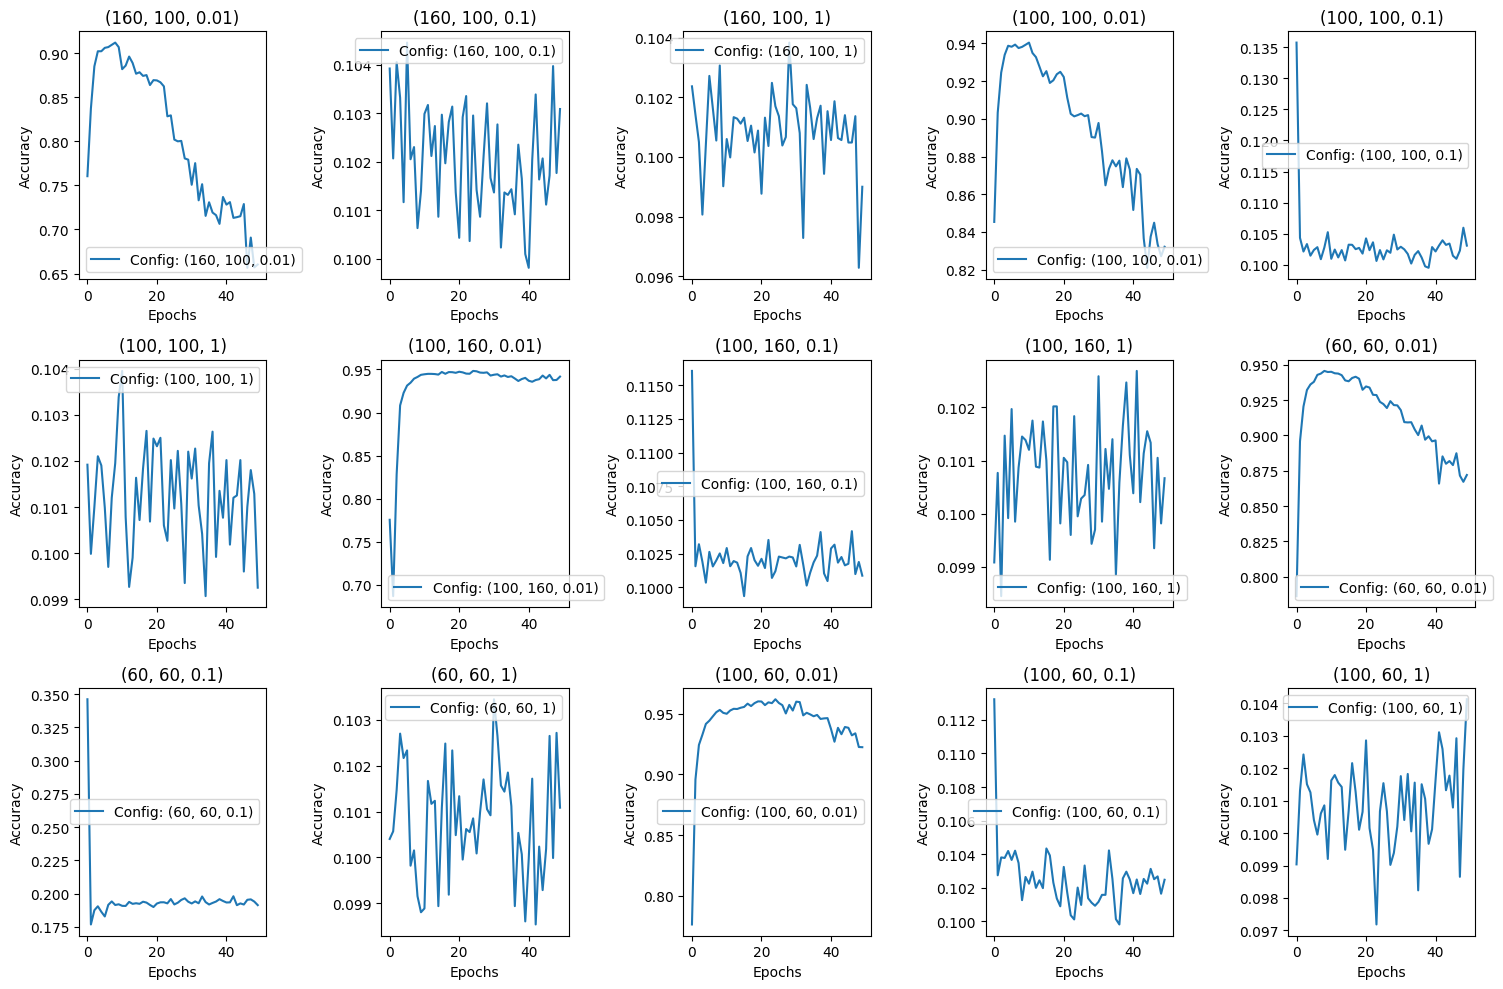

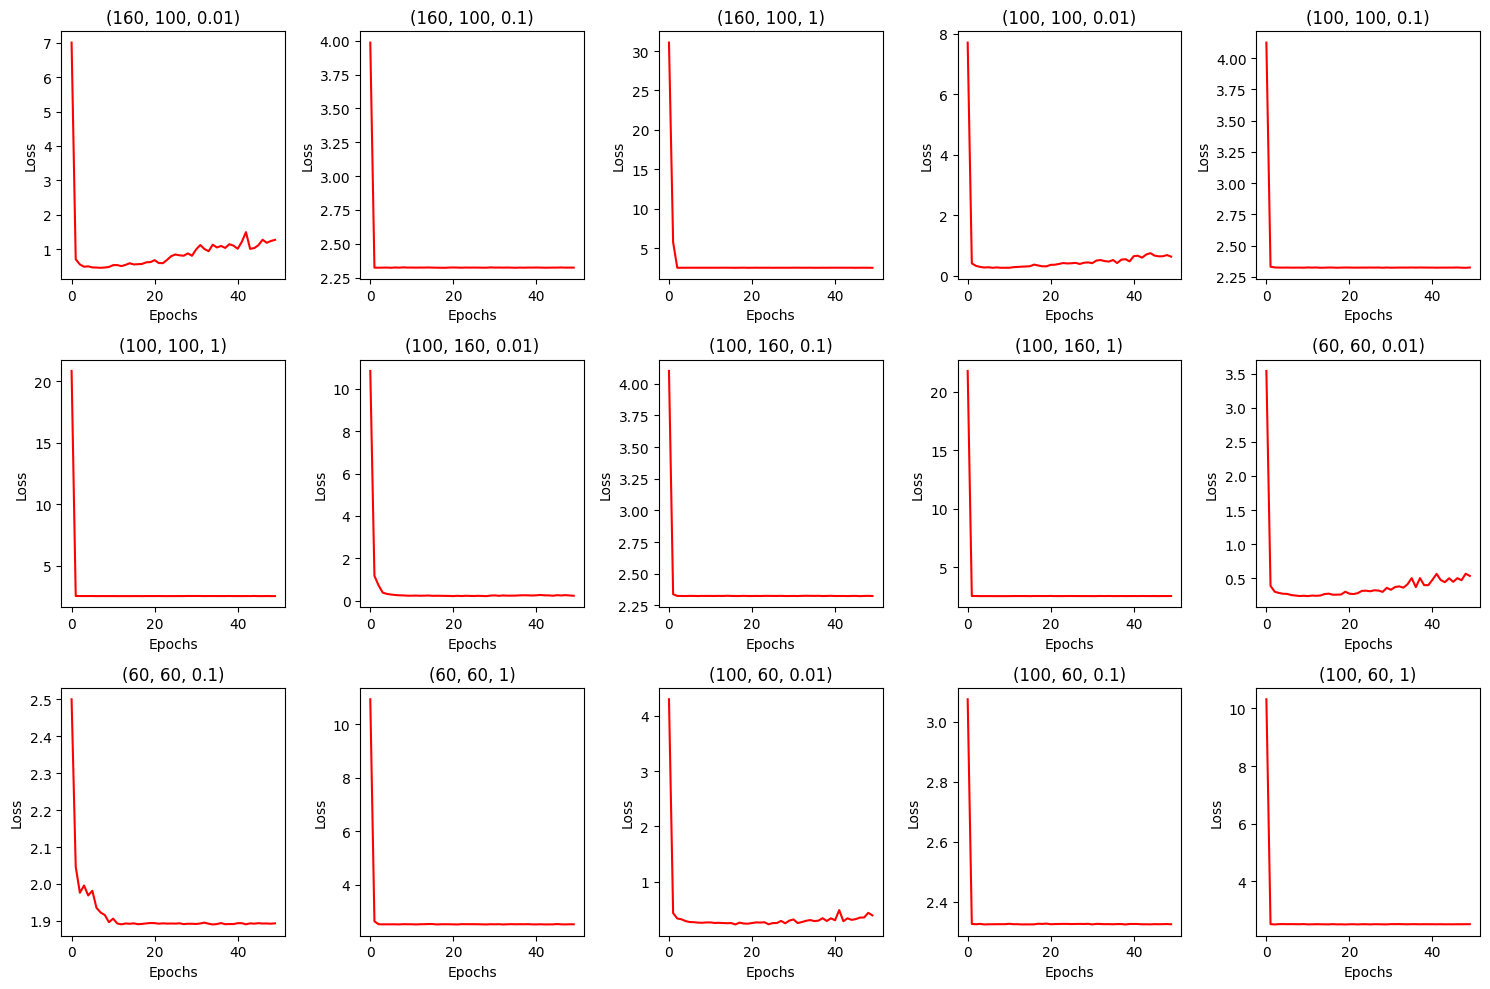

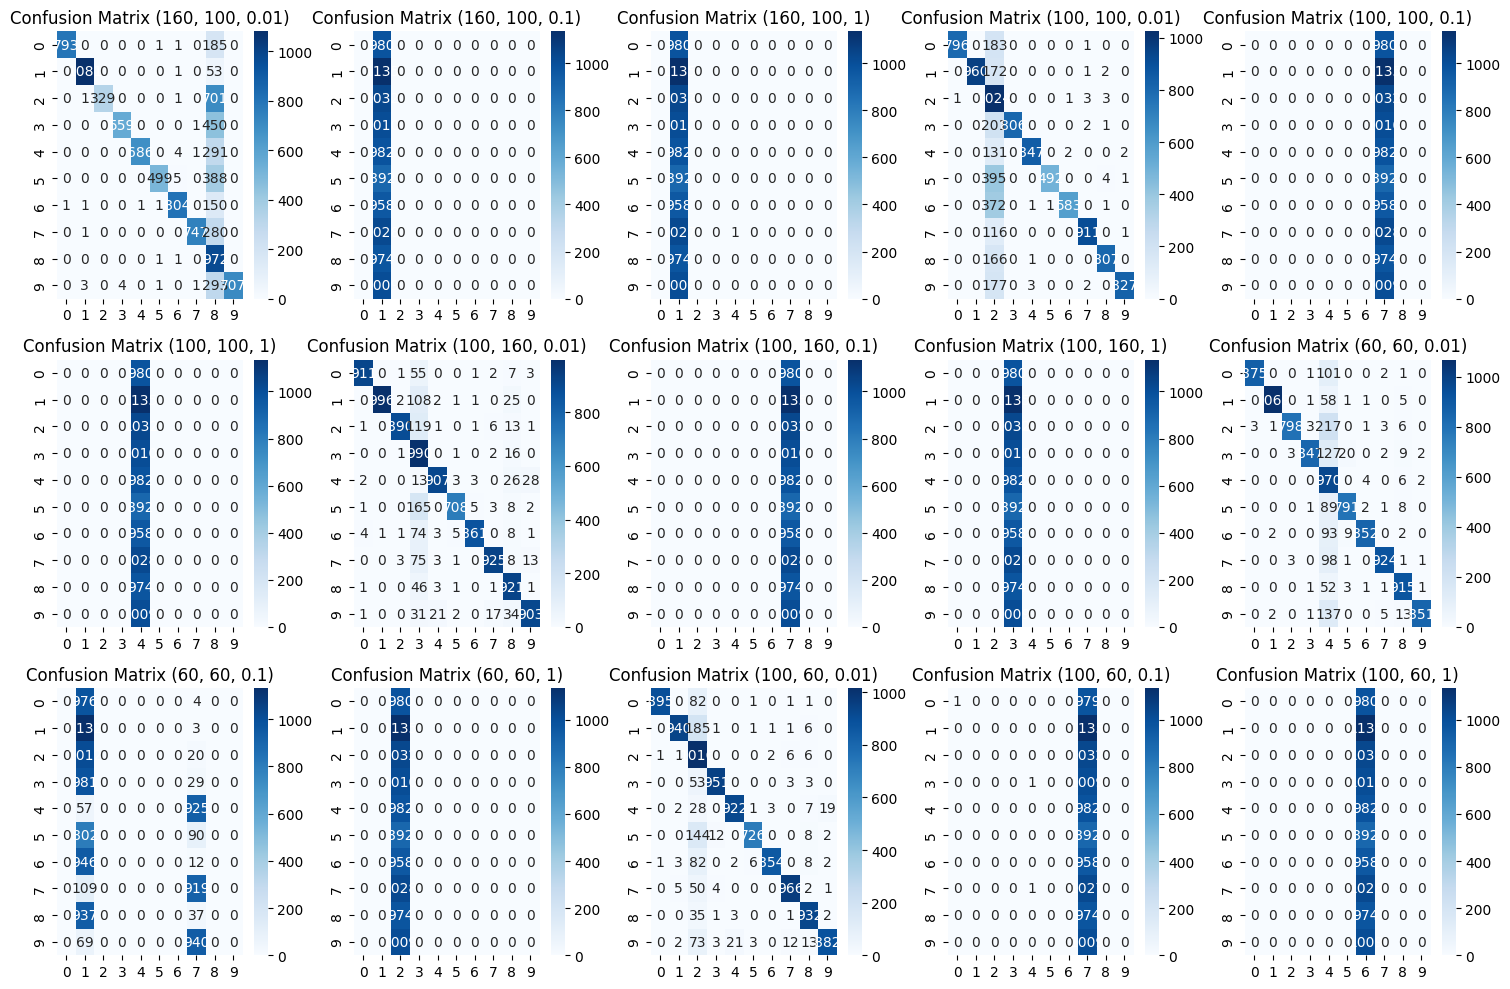


  Hidden Layers  Learning Rate  Test Accuracy  Training Time(sec)
0      [60, 60]           0.01      88.919388         2791.093577
1      [60, 60]           0.10      20.510160         2800.899892
2      [60, 60]           1.00      10.320067         2860.730798
3     [100, 60]           0.01      90.839310         2923.419902
4     [100, 60]           0.10      10.280064         3064.538045
5     [100, 60]           1.00       9.580060         3120.987013


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
with open("/content/drive/MyDrive/NN_LAB/exp4_output/results_final1.json", "r") as f:
        results += json.load(f)
df = pd.DataFrame(results, columns=["Hidden Layers", "Learning Rate", "Test Accuracy", "Training Time(sec)"])
print(df)


# Plot Accuracy Curves
plt.figure(figsize=(15, 10))
for i, key in enumerate(accuracy_curves.keys()):
    plt.subplot(3, 5, i + 1)
    plt.plot(accuracy_curves[key], label=f"Config: {key}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{key}")
    plt.legend()
plt.tight_layout()
plt.show()
print()
# Plot Loss Curves
plt.figure(figsize=(15, 10))
for i, key in enumerate(loss_curves.keys()):
    plt.subplot(3, 5, i + 1)
    plt.plot(loss_curves[key], label=f"Config: {key}", color='red')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{key}")
    # plt.legend()
plt.tight_layout()
plt.show()
print()
# Plot Confusion Matrices
plt.figure(figsize=(15, 10))
for i, key in enumerate(confusion_matrices.keys()):
    plt.subplot(3, 5, i + 1)
    sns.heatmap(confusion_matrices[key], annot=True, cmap="Blues", fmt='d')
    plt.title(f"Confusion Matrix {key}")
plt.tight_layout()
plt.show()
print()
# Display Test Accuracy & Training Time in Tabular Format
df = pd.DataFrame(results, columns=["Hidden Layers", "Learning Rate", "Test Accuracy", "Training Time(sec)"])
print(df)


In [24]:
import pandas as pd

df = pd.DataFrame(results, columns=["Hidden Layers", "Learning Rate", "Test Accuracy", "Training Time(sec)"])
print(df)

  Hidden Layers  Learning Rate  Test Accuracy  Training Time(sec)
0      [60, 60]           0.01      88.919388         2791.093577
1      [60, 60]           0.10      20.510160         2800.899892
2      [60, 60]           1.00      10.320067         2860.730798
3     [100, 60]           0.01      90.839310         2923.419902
4     [100, 60]           0.10      10.280064         3064.538045
5     [100, 60]           1.00       9.580060         3120.987013


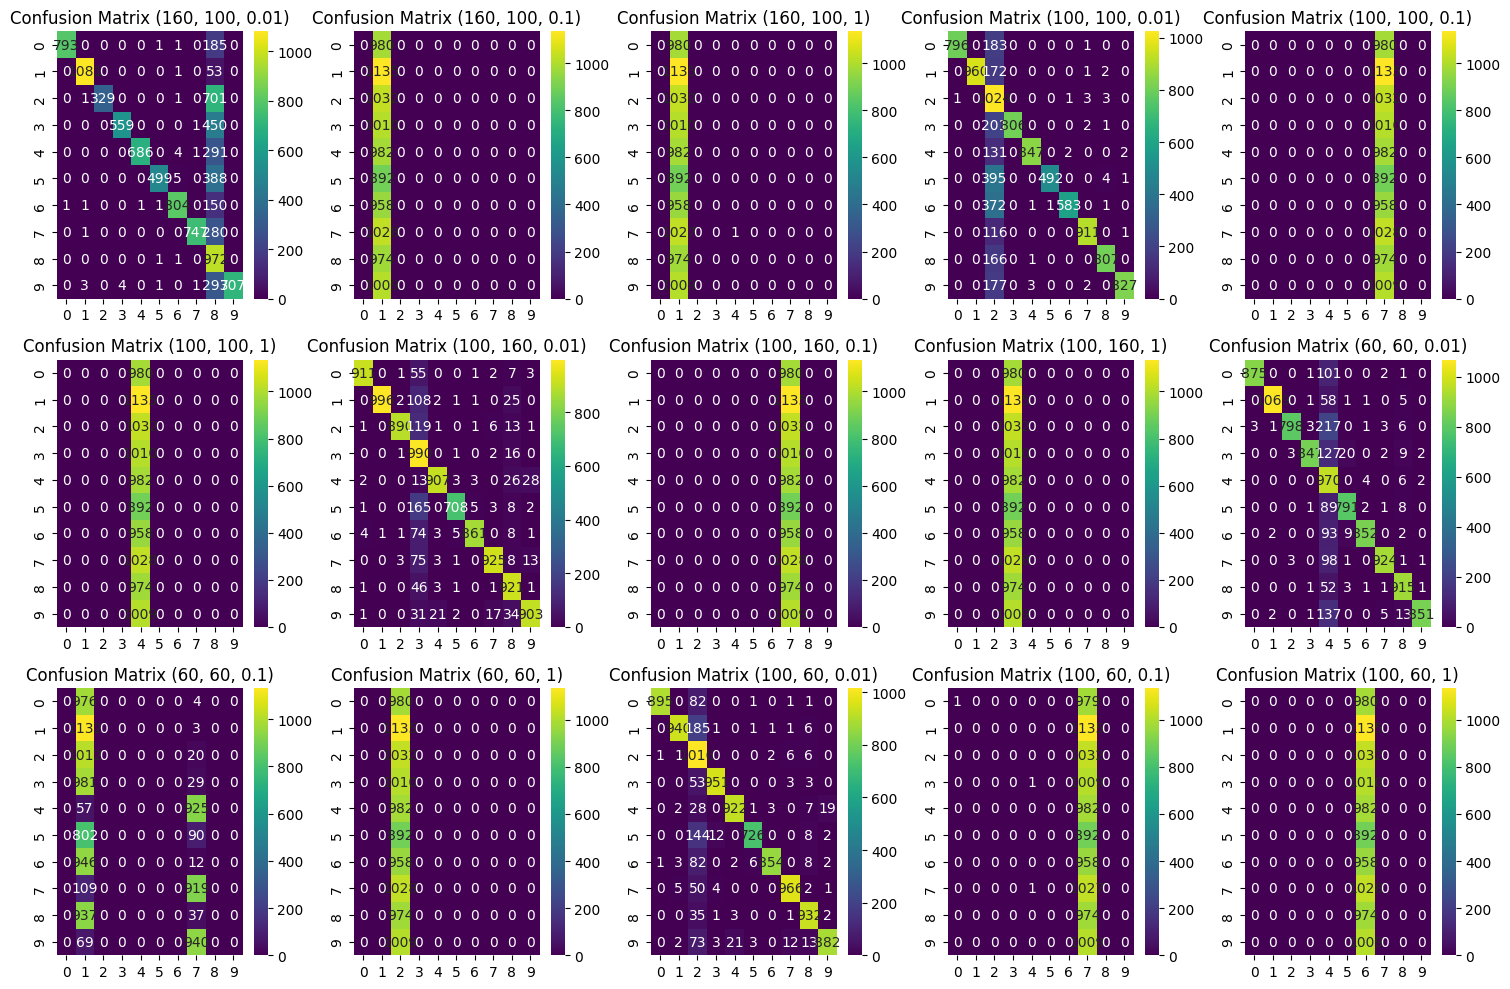

In [26]:
# Plot Confusion Matrices
plt.figure(figsize=(15, 10))
for i, key in enumerate(confusion_matrices.keys()):
    plt.subplot(3, 5, i + 1)
    sns.heatmap(confusion_matrices[key], annot=True, cmap="viridis", fmt='d')
    plt.title(f"Confusion Matrix {key}")
plt.tight_layout()
plt.show()

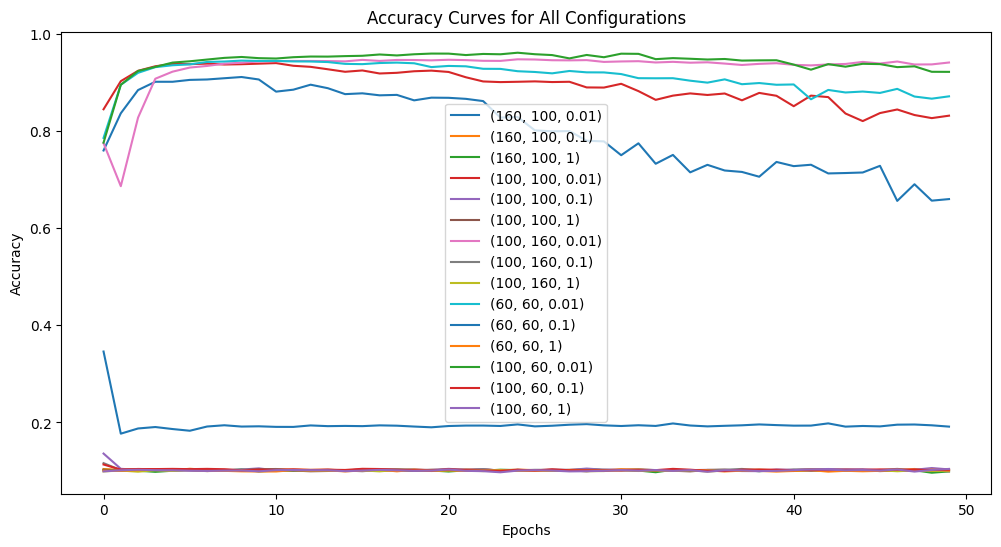

In [27]:
plt.figure(figsize=(12, 6))
for key, values in accuracy_curves.items():
    plt.plot(values, label=f"{key}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves for All Configurations")
plt.legend()
plt.show()